In [1]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset, TensorDataset, SubsetRandomSampler
from torchvision.datasets import FashionMNIST

import torchvision

import sys

import matplotlib.pyplot as plt

import tqdm

import pandas as pd

from typing import Sequence, Tuple, Optional, List

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create Data

In [3]:
nImages = 3000
imgSize = 64

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)

for i in range(nImages):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  width = np.random.rand()/.6 + 1.8 # random width
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

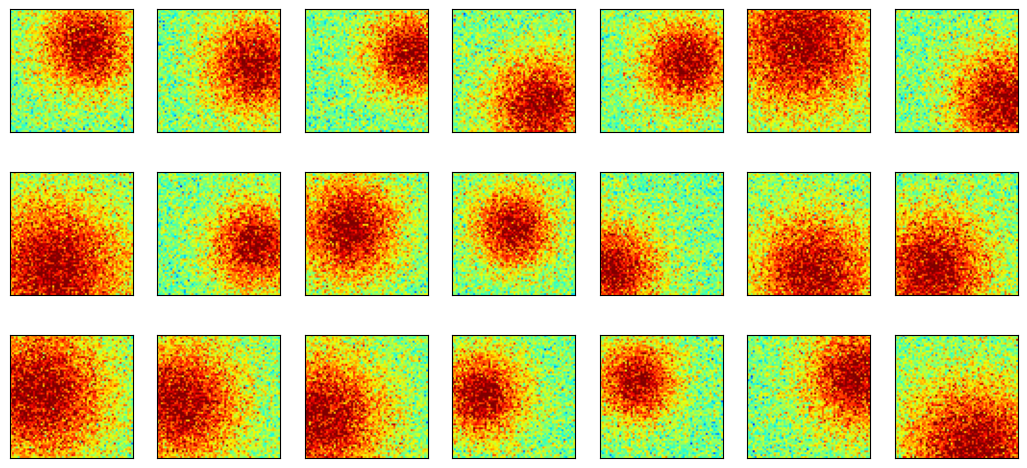

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create the Discriminator and Generator Models

In [5]:
class discriminatorNet(nn.Module):
  def __init__(self,d_printtoggle:bool = False):
    super().__init__()

    self.print = d_printtoggle

    # convolution layers
    self.conv1 = nn.Conv2d(  1, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    if self.print: print(x.shape)
    x = F.leaky_relu( self.conv1(x) ,.2)
    if self.print: print(x.shape)
    x = F.leaky_relu( self.conv2(x) ,.2)
    if self.print: print(x.shape)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    if self.print: print(x.shape)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    if self.print: print(x.shape)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

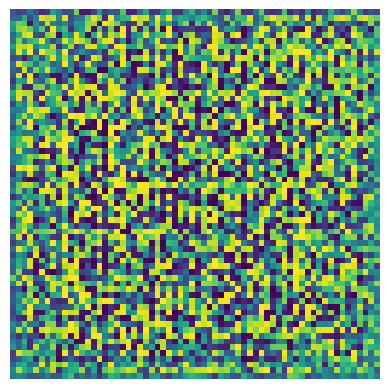

In [6]:
class generatorNet(nn.Module):
  def __init__(self,g_printtoggle: bool = False):
    super().__init__()

    self.print = g_printtoggle

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   1, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    if self.print: print(x.shape)
    x = F.relu( self.bn1(self.conv1(x)) )
    if self.print: print(x.shape)
    x = F.relu( self.bn2(self.conv2(x)) )
    if self.print: print(x.shape)
    x = F.relu( self.bn3(self.conv3(x)) )
    if self.print: print(x.shape)
    x = F.relu( self.bn4(self.conv4(x)) )
    if self.print: print(x.shape)
    x = torch.tanh( self.conv5(x) )
    if self.print: print(x.shape)
    return x


gnet = generatorNet(False)
y = gnet(torch.randn(10,100,1,1))
# print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy())
plt.axis('off')
plt.show();

# Train the Model

In [7]:
lossfun = nn.BCELoss()

d_printtoggle = False
g_printtoggle = False

dnet = discriminatorNet(d_printtoggle).to(device)
gnet = generatorNet(g_printtoggle).to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5,.999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5,.999))

In [8]:
from torch.cuda.amp import GradScaler

from time import time

 # ---------- AMP (new API); enable only on CUDA ----------
use_cuda = (device.type == "cuda")
scaler = torch.amp.GradScaler(enabled=use_cuda)


# training parameters and initializations
num_epochs = 1500
batchsize  = 86
losses     = []
disDecs    = []

start_time = time()

for epochi in range(num_epochs):

  # create a minibatch from randomly selected images
  ridx = torch.randint(images.shape[0],(batchsize,))
  data = images[ridx,:].to(device)


  # create labels for real and fake images
  real_labels = torch.ones(batchsize,1).to(device)
  fake_labels = torch.zeros(batchsize,1).to(device)



  ### ---------------- Train the discriminator ---------------- ###

  # forward pass and loss for REAL pictures
  pred_real   = dnet(data)                     # output of discriminator
  d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

  # forward pass and loss for FAKE pictures
  fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
  fake_images = gnet(fake_data)                           # output of generator
  pred_fake   = dnet(fake_images)                  # pass through discriminator
  d_loss_fake = lossfun(pred_fake,fake_labels)            # all labels are 0

  # collect loss (using combined losses)
  d_loss = d_loss_real + d_loss_fake

  # backprop
  if use_cuda:
    scaler.scale(d_loss).backward()
    scaler.step(d_optimizer)
    scaler.update()
  else:
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



  ### ---------------- Train the generator ---------------- ###

  # create fake images and compute loss
  fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
  pred_fake   = dnet(fake_images)

  # compute loss
  g_loss = lossfun(pred_fake,real_labels)

  # backprop
  if use_cuda:
    scaler.scale(g_loss).backward()
    scaler.step(g_optimizer)
    scaler.update()
  else:
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


  # collect losses and discriminator decisions
  losses.append([d_loss.item(),g_loss.item()])

  d1 = torch.mean((pred_real>.5).float()).detach().cpu().item()
  d2 = torch.mean((pred_fake>.5).float()).detach().cpu().item()
  disDecs.append([d1,d2])

  elapsed = time() - start_time

  mins, secs = divmod(elapsed, 60)
  hours, mins = divmod(mins, 60)

  # print out a status message
  if (epochi+1)%50==0:
    msg = f'Finished epoch {epochi+1}/{num_epochs} in {int(hours)}h: {int(mins)}m: {int(secs)}s'
    sys.stdout.write('\n' + msg)

# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)


Finished epoch 50/1500 in 0h: 0m: 7s
Finished epoch 100/1500 in 0h: 0m: 14s
Finished epoch 150/1500 in 0h: 0m: 21s
Finished epoch 200/1500 in 0h: 0m: 28s
Finished epoch 250/1500 in 0h: 0m: 36s
Finished epoch 300/1500 in 0h: 0m: 43s
Finished epoch 350/1500 in 0h: 0m: 50s
Finished epoch 400/1500 in 0h: 0m: 57s
Finished epoch 450/1500 in 0h: 1m: 3s
Finished epoch 500/1500 in 0h: 1m: 10s
Finished epoch 550/1500 in 0h: 1m: 17s
Finished epoch 600/1500 in 0h: 1m: 24s
Finished epoch 650/1500 in 0h: 1m: 31s
Finished epoch 700/1500 in 0h: 1m: 38s
Finished epoch 750/1500 in 0h: 1m: 45s
Finished epoch 800/1500 in 0h: 1m: 52s
Finished epoch 850/1500 in 0h: 1m: 59s
Finished epoch 900/1500 in 0h: 2m: 6s
Finished epoch 950/1500 in 0h: 2m: 13s
Finished epoch 1000/1500 in 0h: 2m: 20s
Finished epoch 1050/1500 in 0h: 2m: 27s
Finished epoch 1100/1500 in 0h: 2m: 34s
Finished epoch 1150/1500 in 0h: 2m: 41s
Finished epoch 1200/1500 in 0h: 2m: 48s
Finished epoch 1250/1500 in 0h: 2m: 55s
Finished epoch 1300/15

In [9]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

# Plot the metrics

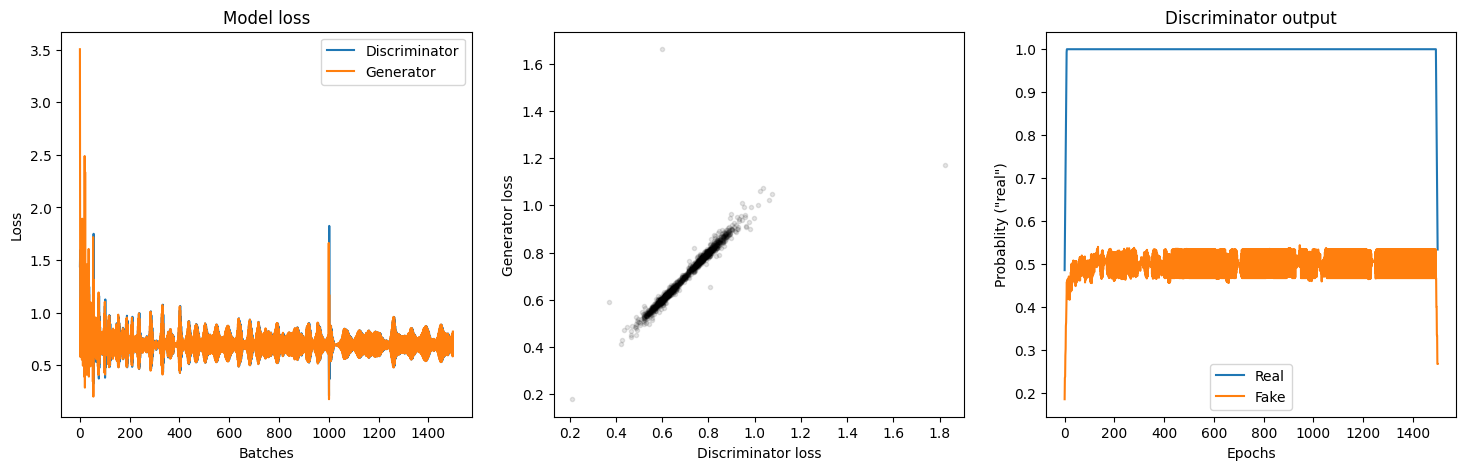

In [22]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses[:,0],label='Discriminator')
ax[0].plot(losses[:,1],label='Generator')
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0.7,0.8])


ax[1].plot(losses[200:,0],losses[200:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show();

# Visualize some images

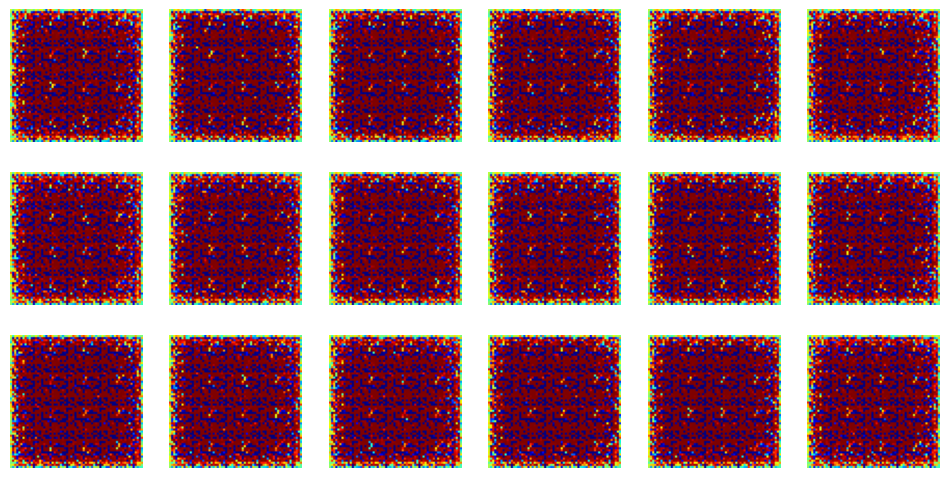

In [11]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show();